## Cargamos todas las bibliotecas necesarias para ejecutar todos los métodos del jupyter. 

Es buena costumbre cargarlos al principio, asi no se estar cargando en memoria repetidas veces cada paquete

In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
import matplotlib
warnings.filterwarnings('ignore')

In [3]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['font.size'] = 2

### Creación de funciones auxiliares

In [4]:
def discretize(df, column):
    q1 = df_final[column].quantile(.25)
    q2 = df_final[column].quantile(.5)
    q3 = df_final[column].quantile(.75)
    df[column+"_in_q1"] = 0
    df[column+"_in_q2"] = 0
    df[column+"_in_q3"] = 0
    df[column+"_in_q4"] = 0
    df[column+"_in_q1"] = list(map(lambda x: 1 if x <=q1 else 0, df[column]))
    df[column+"_in_q2"] = list(map(lambda x: 1 if (q1 < x and x <=q2) else 0, df[column]))
    df[column+"_in_q3"] = list(map(lambda x: 1 if (q2 < x and x <=q3) else 0, df[column]))
    df[column+"_in_q4"] = list(map(lambda x: 1 if x>q3 else 0, df[column]))
    df.drop(column, axis=1, inplace=True)
    return df

In [5]:
def is_object(df,column,object_name):
    df["is_"+str(object_name)] = list(map(lambda x: 1 if x == object_name else 0, df[column]))
    return df
    

In [6]:
def find_and_replace_nans(df,col,rate_to_complete):
    
    index_list = df[col][df[col].isnull()].sample(frac=rate_to_complete,random_state=1).index.tolist()
    
    if len(index_list)>0:
        moda = df[(~df[col].isnull())][col].mode()[0]
        df.loc[index_list,col] = moda
    return df
    
def complete_nans(df,null_cols,rate_to_complete,method):
    if method=="moda_por_clase":
        for col in null_cols:
            df0 = find_and_replace_nans(df[df.target==0.0],col,rate_to_complete)
            df1 = find_and_replace_nans(df[df.target==1.0],col,rate_to_complete)
            df = pd.concat([df0,df1])
    else:
        for col in null_cols:
            df = find_and_replace_nans(df,col,rate_to_complete)
    
    return df.dropna()
            
            
        

In [7]:
def preprocess(df, metodo, rate_to_complete):
    
    # Extraemos las filas de la columna 'model' que tienen valores NaNs y luego los completamos con un valor por defecto
    
    #model_null_indexes = df[df.model.isnull()].index.tolist()
    #df.loc[model_null_indexes,"model"] = "other other"
    
    df['model'] = df['model'].fillna('other other')
    
    # Obtenemos las columnas que tienen al menos un NaN
    cols_in_null = df.columns[df.isnull().sum(axis=0)>0].tolist()
    
    # Los completamos con un rate_to_complete y utilizando un determinado metodo
    df_comp = complete_nans(df,cols_in_null,rate_to_complete,metodo)
    
    # Discretizamos las columnas que ya sabemos que tienen una distribucion dada (Chi, Normal)
    # (Se usan cuantiles para ver en qué segmento caen)
    for column in ["diff_time_days_minnone","diff_time_dayssearch engine hit","COUNT(users_logs)","number_visits_model","diff_time_daysbrand listing","diff_time_daysnone"]:
        df_comp = discretize(df_comp,column)
    
    # De la columna 'model' extraemos marca y modelo del celular visitado o  comprado
    df_comp["marca"] = df_comp.model.str.split(" ",1,expand=True)[0]
    df_comp["modelo"] = df_comp.model.str.split(" ",1,expand=True)[1]
    
    # Determinamos de que marca se trata
    df_comp["is_iphone"] = list(map(lambda x: 1 if x=="iPhone" else 0, df_comp["marca"]))
    df_comp["is_samsung"] = list(map(lambda x: 1 if x=="Samsung" else 0, df_comp["marca"]))
    df_comp["is_motorola"] = list(map(lambda x: 1 if x=="Motorola" else 0, df_comp["marca"]))
    df_comp["is_lg"] = list(map(lambda x: 1 if x=="LG" else 0, df_comp["marca"]))
    df_comp["is_sony"] = list(map(lambda x: 1 if x=="Sony" else 0, df_comp["marca"]))
    df_comp["is_other"] = list(map(lambda x: 1 if (x!="Sony" and x!="LG" and x!="Motorola" and x!="Samsung" and x!="iPhone") else 0, df_comp["marca"]))
    
    # determinamos de que modelo se trata
    pop_models = ['6','5s','6S','Galaxy J5','7','7 Plus','Galaxy S8','Galaxy S7','Galaxy S7 Edge','Galaxy J7 Prime','Moto G2 3G Dual','Galaxy S6 Edge','Galaxy S6 Flat','5c','6S Plus','Galaxy J7','6 Plus','Moto G4 Plus','SE','Galaxy Gran Prime Duos TV','4S','Galaxy S8 Plus','5','Moto G3 4G','Galaxy A5 2017','Moto X Play 4G Dual','Moto G5 Plus','Galaxy A7 2017','Moto X2','Galaxy A5']
    for model in pop_models:
        df_comp = is_object(df_comp,"modelo",model)

    df_comp["is_other_model"] = list(map(lambda x: 1 if x not in pop_models else 0, df_comp["modelo"]))
    
    # Eliminamos las columnas con strings
    df_comp.drop(["model","marca","modelo"],axis=1,inplace=True)
    
    return df_comp




In [8]:
def test_completitud(train, test, feature_columns, metodo, best_depth):
    dtree = DecisionTreeClassifier(max_depth=5, criterion='gini') 
    completitud_precision_tamanio = {"completitud":[], "precision":[], "tamanio":[]}
    for p in np.arange(0.0,.85,.05):   
        df_train_p = preprocess(train,metodo,p)
        scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                            df_train_p[feature_columns].values, # X_train features
                            df_train_p["target"].values, # Y_train targets
                            scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                            return_train_score = True, # Queremos ver los scorings de los training folds
                            return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                            cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                            n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                           )
        best_dtree_index = np.argmax(scores["test_roc_auc"])
        best_btree = scores["estimator"][best_dtree_index]

        y_esperado = test.target.values
        y_pred = best_btree.predict(test[feature_columns].values)

        accuracy = accuracy_score(y_esperado, y_pred)
        tamanio = best_btree.tree_.node_count

        completitud_precision_tamanio["completitud"].append(100.0*p)
        completitud_precision_tamanio["precision"].append(accuracy)
        completitud_precision_tamanio["tamanio"].append(tamanio)
        
    return completitud_precision_tamanio

## Cargamos los datasets para construir el dataset final

In [9]:
df_first = pd.read_csv('../../data_aa/first_part_dataset.csv')

df_second = pd.read_csv('../../data_aa/second_part_dataset.csv')

df_thrid = pd.read_csv('../../data_aa/thrid_part_dataset.csv')

In [10]:
df_first = df_first.rename(columns={'person_id': 'person'})

df_first = df_first.drop(columns=['Unnamed: 0'])

In [11]:
df_second.columns.values

array(['Unnamed: 0', 'person', 'diff_time_days_minnone',
       'diff_time_daysnone', 'diff_time_dayscheckout',
       'diff_time_daysconversion', 'diff_time_daysbrand listing',
       'diff_time_dayssearch engine hit', 'diff_time_start_end', 'model',
       'number_visits_model'], dtype=object)

In [12]:
df_second = df_second.drop(columns=['Unnamed: 0'])

In [13]:
df_thrid.columns.values

array(['Unnamed: 0', 'person', 'COUNT(users_logs)', 'avg_time_events'],
      dtype=object)

In [14]:
df_thrid = df_thrid.drop(columns=['Unnamed: 0'])

In [15]:
df_final = pd.merge(df_first, df_second, on='person', how='left')

df_final = pd.merge(df_final, df_thrid, on='person', how='left')

In [16]:
df_final.target.isin([1.0]).shape

(19414,)

### Significado de las columnas:

 ##### - Las columnas 'Android', 'BlackBerry', 'Chrome', 'FreeBSD', 'Linux', 'Mac', 'Tizen', 'Ubuntu', 'Unknown', 'Windows','iOS' indican la cantidad de veces que cada usuario ingreso a la pagina de Trocafone utilizando uno de esos esos sistemas operativos. Por ejemplo, si el valor de 'Android' para un usuario es 2 siginfica que ese usuario entro a la pagina dos veces desde un dispositivo con un sistema operativo Android
 
#####  - Las columnas 'Computer', 'Smartphone', 'Tablet' indican la cantidad de veces que cada usuario ingreso a la pagina de Trocafone utilizando uno de esos dispositivos
 
#####  - Las columnas 'ad campaign hit', 'brand listing', 'checkout', 'conversion', 'generic listing', 'lead','search engine hit', 'searched products', 'staticpage','viewed product', 'visited site' indican la cantidad de veces que cada usuario realizo cada uno de esos eventos
 
#####  - La columna 'diff_time_days_minnone' indica la cantidad de tiempo que paso desde el primer evento que realizo el usuario hasta el 2018/06/01
 
#####  - La columna 'diff_time_daysnone' indica la cantidad de tiempo que paso desde el ultimo evento que el usuario realizo en la pagina hasta el 2018/06/01
 
#####  - La columna 'diff_time_dayscheckout' indica la cantidad de tiempo que paso desde que el usuario realizo el ultimo checkout hasta el 2018/06/01
 
#####  - La columna 'diff_time_daysconversion' indica la cantidad de tiempo que paso desde que el usuario realizo la ultima conversion hasta el 2018/06/01
 
#####  - La columna 'diff_time_daysbrand listing' indica la cantidad de tiempo que paso desde que el usuario realizo la ultima brand listing hasta el 2018/06/01
 
#####  - La columna 'diff_time_dayssearch engine hit' indica la cantidad de tiempo que paso desde que el usuario realizo el ultimo engine hit hasta el 2018/06/01
 
#####  - La columna 'diff_time_start_end' indica la cantidad de tiempo que paso entre el primer evento que realizo el usuario en la pagina y el ultimo
 
#####  - La columna 'model' indica el modelo de celuar que el usuario mas veces visito
 
#####  - La columna 'number_visits_model' indica cuantas veces el usuario visito el celular que mas visito
 
#####  - La columna 'COUNT(users_logs)' indica la cantidad de eventos que el usuario realizo en la pagina
 
#####  - La columna 'avg_time_events' indica el tiempo promedio que paso entre los eventos realizados por cada usuario

##### - La columna 'Target' indica si el usuario realizo una conversion en la pagina durante el periodo que va desde la fecha 2018/06/01 hasta la 2018/06/15
 

### Eliminamos las columnas con muy pocas variables o alta corrleación (Ej. Windows ~ Computer)

In [17]:
df_final.drop(["BlackBerry","Chrome","FreeBSD","Linux","Mac","Other","Tizen","Ubuntu","Unknown","Windows","person"],
              axis=1,
              inplace=True)

### Transformamos algunas columnas para que su distribución se ajuste a una Chi cuadrado o Normal. Luego discretizamos por cuantiles

In [18]:
df_final.loc[:,"diff_time_daysnone"] = np.log10(df_final["diff_time_daysnone"]+1.)
df_final.loc[:,"diff_time_days_minnone"] = np.log10(df_final.diff_time_days_minnone+1.)
df_final.loc[:,"diff_time_dayssearch engine hit"] = np.log10(df_final["diff_time_dayssearch engine hit"]+1.0)
df_final.loc[:,"COUNT(users_logs)"] = np.log10(df_final["COUNT(users_logs)"]+1.)
df_final.loc[:,"number_visits_model"] = np.log10(1.+df_final.number_visits_model)
df_final.loc[:,"diff_time_daysbrand listing"] = np.log10(01.+df_final["diff_time_daysbrand listing"])

In [19]:
df_final['model'].head()

0                         NaN
1                    iPhone 7
2                   iPhone 6S
3    Motorola Moto G2 3G Dual
4      Samsung Galaxy S8 Plus
Name: model, dtype: object

### En el siguiente metodo  se realiza todo el preprocess de los datos.

In [20]:
df_completo = preprocess(df_final.copy(),"moda",1.)

### Vamos a seleccionar solo 980 casos que no realizaron una compra para balancear el dataset

In [21]:
df_completo_reduced_1 = df_completo[df_completo['target']==1]
print(len(df_completo_reduced_1.index))

980


In [22]:
df_completo_reduced_0 = df_completo[df_completo['target']==0].sample(n=980, random_state=1)
print(len(df_completo_reduced_0.index))

980


In [23]:
df_train = pd.concat([df_completo_reduced_1, df_completo_reduced_0])
del df_completo_reduced_0, df_completo_reduced_1

### Nos quedamos con aquellas columnas que no sean target

In [24]:
feature_columns = list(set(df_train.columns.tolist())-set(["target"]))

### Obtenemos el dataset de test y lo eliminamos del dataset de train

In [25]:
df_test = df_train.sample(frac=0.2, random_state=2)
df_train.drop(df_test.index,axis=0,inplace=True)
train_indexes = df_train.index.tolist()

In [26]:
len(df_test)

392

### Verificamos el balance de categorías en cada datset

In [27]:
N_train = df_train.shape[0]*1.
N_test = df_test.shape[0]*1.

N_train_1 = df_train.target.sum()
N_train_0 = df_train.shape[0]*1.-N_train_1

N_test_1 = df_test.target.sum()
N_test_0 = df_test.shape[0]*1.-N_test_1

In [28]:
print("Porcentaje de casos positivos en el train: %" + str(100.0*N_train_1/N_train))
print("Porcentaje de casos positivos en el test: %" + str(100.0*N_test_1/N_test))

Porcentaje de casos positivos en el train: %50.255102040816325
Porcentaje de casos positivos en el test: %48.97959183673469


## Utilizando únicamente el dataset de train ejecutamos 5-fold Cross Validation

In [29]:
scoring = ['accuracy','roc_auc']

In [30]:
dtree = DecisionTreeClassifier(max_depth=3, criterion='gini') 

In [31]:
scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                        df_train[feature_columns].values, # X_train features
                        df_train["target"].values, # Y_train targets
                        scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                        return_train_score = True, # Queremos ver los scorings de los training folds
                        return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                        cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                        n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                       )



### Cargamos los resultados en un DF de Pandas

In [32]:
cv_5_fold_resultados = pd.DataFrame(scores)
cv_5_fold_resultados.drop(["fit_time","score_time","estimator"],axis=1,inplace=True)

In [33]:
cv_5_fold_resultados

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.732484,0.767145,0.791728,0.828612
1,0.767516,0.763955,0.836356,0.824302
2,0.707006,0.779904,0.753185,0.842019
3,0.760383,0.768127,0.802344,0.833754
4,0.766773,0.764143,0.812388,0.830726


### Calculamos los estadisticos de cada experimento, tanto para train como para test

In [34]:
cv_5_fold_resultados.describe()

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
count,5.000000,5.000000,5.000000,5.000000
mean,0.746833,0.768655,0.799200,0.831883
std,0.026463,0.006549,0.030568,0.006629
min,0.707006,0.763955,0.753185,0.824302
25%,0.732484,0.764143,0.791728,0.828612
50%,0.760383,0.767145,0.802344,0.830726
75%,0.766773,0.768127,0.812388,0.833754
max,0.767516,0.779904,0.836356,0.842019


### Seleccionamos el árbol que mejor accuracy haya tenido durante el train

In [35]:
best_dtree_index = np.argmax(scores["test_accuracy"]*scores["test_roc_auc"])

In [36]:
best_btree = scores["estimator"][best_dtree_index]

### Evaluamos su accuracy sobre el 20% restante del dataset que no formó parte del 5-fold CV

In [37]:
y_esperado = df_test.target.values
y_pred = best_btree.predict(df_test[feature_columns].values)

In [38]:
print("Score validation: " + str(accuracy_score(y_esperado, y_pred)))

Score validation: 0.7831632653061225


In [39]:
# dot_data = StringIO()
# export_graphviz(best_btree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

## 2.2

In [44]:
def get_performance_models(dataframe, depths, criterions):
    
    d = {'comb_hiperparamentros': [], 'test_accuracy': [],  'train_accuracy': [], 'test_roc_auc': [], 'train_roc_auc': []}
    
    df = pd.DataFrame(data=d)
    
    for criterion in criterions:
        
        for depth in depths:
            
            dtree = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
            
            scoring = ['accuracy','roc_auc']
    
            scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                                df_train.drop(columns=['target']).values, # X_train features
                                df_train["target"].values, # Y_train targets
                                scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                                return_train_score = True, # Queremos ver los scorings de los training folds
                                return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                                cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                                n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                               )
        
            cv_5_fold_resultados = pd.DataFrame(scores)
            
            cv_5_fold_resultados.drop(["fit_time","score_time","estimator"],axis=1,inplace=True)
            
            cv_5_fold_resultados['comb_hiperparamentros'] = [criterion + '_' + str(depth)]*5
            
            df = pd.concat([df, cv_5_fold_resultados])
            
    return df

In [46]:
criterions = ['gini', 'entropy']

depths = [3, 6, None]

df_performance = get_performance_models(df_train, depths, criterions)

df_performance

,comb_hiperparamentros,test_accuracy,test_roc_auc,train_accuracy,train_roc_auc
0,gini_3,0.732484,0.791728,0.767145,0.828612
1,gini_3,0.767516,0.836356,0.763955,0.824302
2,gini_3,0.707006,0.753185,0.779904,0.842019
3,gini_3,0.760383,0.802344,0.768127,0.833754
4,gini_3,0.769968,0.814368,0.764143,0.830726
0,gini_6,0.764331,0.766492,0.838915,0.910802
1,gini_6,0.764331,0.778704,0.850877,0.914316
2,gini_6,0.716561,0.742231,0.847687,0.906962
3,gini_6,0.757188,0.780377,0.841434,0.907745
4,gini_6,0.795527,0.837335,0.836653,0.898327


### Obtenemos el modelo que mejor performance tuvo

In [48]:
df_performance[df_performance['test_accuracy']==df_performance['test_accuracy'].max()]

,comb_hiperparamentros,test_accuracy,test_roc_auc,train_accuracy,train_roc_auc
4,gini_6,0.795527,0.837335,0.836653,0.898327


## Volvemos a correr el 5-fold CV pero completado el dataset de train con un dado porcentaje de completitud

In [ ]:
df_train_80 = preprocess(df_final.loc[train_indexes].copy(),"moda",.25)

In [ ]:
df_final.loc[train_indexes].shape

In [ ]:
scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                        df_train_80[feature_columns].values, # X_train features
                        df_train_80["target"].values, # Y_train targets
                        scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                        return_train_score = True, # Queremos ver los scorings de los training folds
                        return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                        cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                        n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                       )

In [ ]:
cv_5_fold_resultados = pd.DataFrame(scores)
cv_5_fold_resultados.drop(["fit_time","score_time","estimator"],axis=1,inplace=True)

In [ ]:
cv_5_fold_resultados

In [ ]:
cv_5_fold_resultados.describe()

In [ ]:
best_dtree_index = np.argmax(scores["test_accuracy"]*scores["test_roc_auc"])

In [ ]:
best_btree = scores["estimator"][best_dtree_index]

In [ ]:
y_esperado = df_test.target.values
y_pred = best_btree.predict(df_test[feature_columns].values)

In [ ]:
print("Score validation: " + str(accuracy_score(y_esperado, y_pred)))

In [ ]:
# dot_data = StringIO()
# export_graphviz(best_btree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

## Analisis de completitud vs tamanio del arbol

In [ ]:
test_moda = test_completitud(train=df_final.loc[train_indexes].copy(),
                 test=df_test.copy(),
                 feature_columns=feature_columns,
                 metodo="moda",
                 best_depth=5
                )

In [ ]:
test_moda_por_clase = test_completitud(train=df_final.loc[train_indexes].copy(),
                 test=df_test.copy(),
                 feature_columns=feature_columns,
                 metodo="moda_por_clase",
                 best_depth=5
                )

In [ ]:
sns.set(font_scale=2)
fig, ax1 = plt.subplots()
ax1.plot(test_moda["completitud"],test_moda["tamanio"], linewidth=3.0)
ax1.set_xlabel('Porcentaje de completitud')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cantidad de nodos del arbol')
plt.title("Imputacion de datos faltantes por moda")
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(test_moda_por_clase["completitud"],test_moda_por_clase["tamanio"], linewidth=3.0)
ax1.set_xlabel('Porcentaje de completitud')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cantidad de nodos del arbol')
plt.title("Imputacion de datos faltantes por moda")
plt.show()

## 2.4 Tolerancia al ruido

### a) y b)

In [49]:
import random

#### Creamos una funcion que genera un array de un largo determinado con valores 0 y un porcentage de valores random. Los valores random que se generen van a depender de la media de la columna para la cual quiere generarse ruido

In [50]:
def create_array_noise(elements_in_column, percentage_noise, mean_column):
    
    number_noise = round(elements_in_column*percentage_noise)
    
    mu, sigma = 0, mean_column
    
    noise = np.random.normal(mu, sigma, [number_noise,1])
    
    array_noise = noise.tolist()
    
    array_noise_final = []
    
    for item in array_noise:
        
        array_noise_final.append(item[0])
    
    array_no_noise = [0]*(elements_in_column - number_noise)
    
    noise = array_noise_final + array_no_noise
    
    random.shuffle(noise)
    
    return noise    

#### Creamos una funcion que, utilizando la funcion anterior, agrega un % de ruido al atributo que indiquemos de un dataset determinado

In [51]:
def generate_dataset_with_noise(df, name_attribute, percentage_noise):
    
    dataframe = df.copy()
    
    number_observations = len(dataframe[name_attribute].values)
    
    mean_column_attribute = dataframe[name_attribute].mean()
    
    array_noise = create_array_noise(number_observations, percentage_noise, mean_column_attribute)
    
    dataframe[name_attribute] = dataframe[name_attribute] + array_noise
    
    return dataframe

In [52]:
def run_model_familiy_datasets(df_train, df_test, name_attribute):
    
    # Modelo con la mejor combinacion de hiperparametros del punto 2.2
    
    dtree = DecisionTreeClassifier(max_depth=6, criterion='gini')
    
    noise_accuracy_tamanio = {"noise":[], "accuracy":[], "tamanio":[]}
    
    # Niveles de ruido
    
    for noise in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
        
        # Agregamos el ruido al attribute elegido
        
        df_noise = generate_dataset_with_noise(df_train, name_attribute, noise)
        
        scoring = ['accuracy']
        
        scores = cross_validate(dtree, # Instancia de árbol a entrenar en cada fold
                            df_noise.drop(columns=['target']).values, # X_train features
                            df_noise["target"].values, # Y_train targets
                            scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                            return_train_score = True, # Queremos ver los scorings de los training folds
                            return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                            cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                            n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                           )
        
        # Seleccionamos el mejor modelo
        
        best_dtree_index = np.argmax(scores["test_accuracy"])
        best_btree = scores["estimator"][best_dtree_index]

        y_esperado = df_test['target'].values
        y_pred = best_btree.predict(df_test.drop(columns=['target']).values)

        accuracy = accuracy_score(y_esperado, y_pred)
        tamanio = best_btree.tree_.node_count

        noise_accuracy_tamanio["noise"].append(100.0*noise)
        noise_accuracy_tamanio["accuracy"].append(accuracy)
        noise_accuracy_tamanio["tamanio"].append(tamanio)
        
    return noise_accuracy_tamanio
       

In [56]:
df_results_2_4 = run_model_familiy_datasets(df_train, df_test, 'diff_time_start_end')

pd.DataFrame(data=df_results_2_4)

,noise,accuracy,tamanio
0,5.0,0.803571,83
1,10.0,0.795918,85
2,15.0,0.790816,99
3,20.0,0.798469,91
4,25.0,0.785714,99
5,30.0,0.798469,87
6,35.0,0.798469,85


### La performance del modelo no parece verse afectada por el noise. Puede ser porque no es una varaible importante para el mismo?

### c) Graficamos el tamaño del arbol (cantidad de nodos) en funcion del ruido

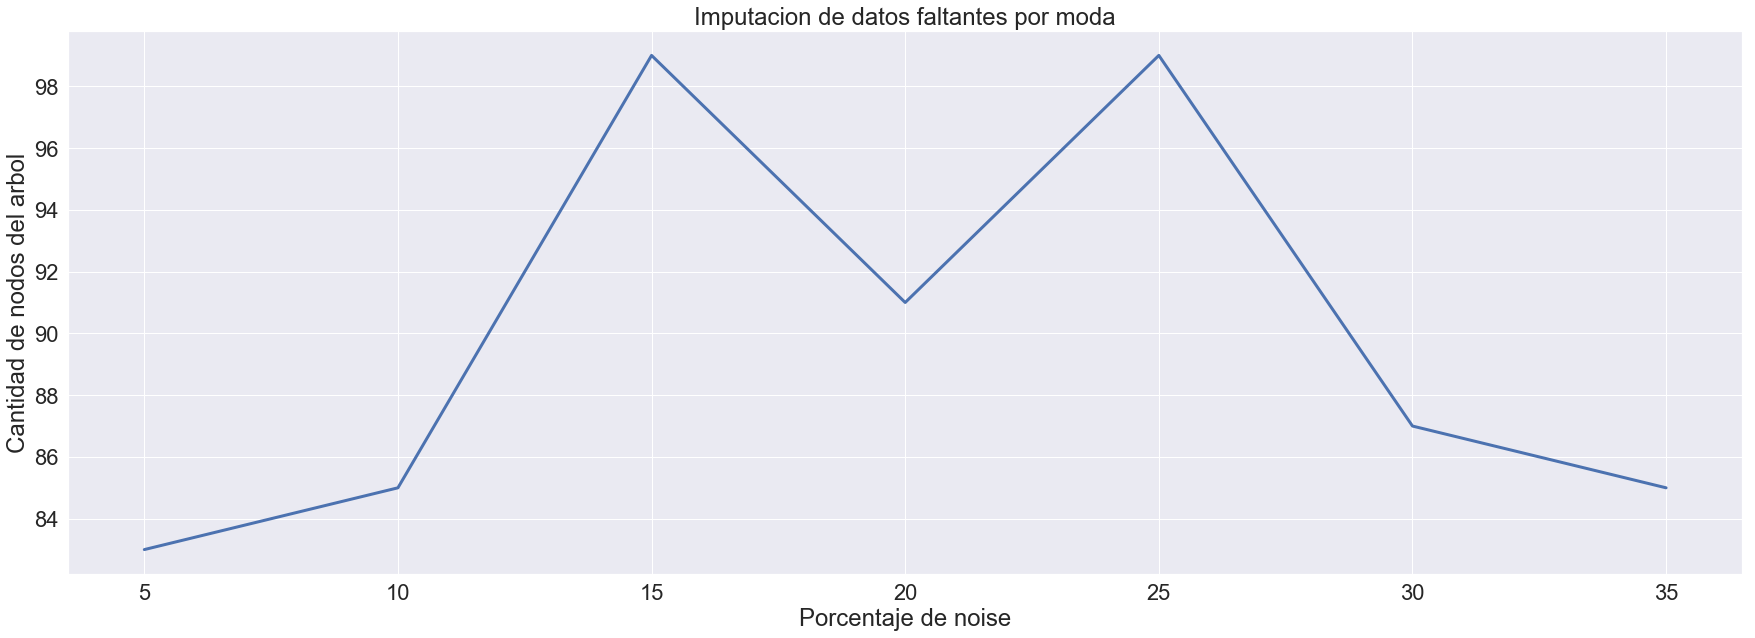

In [57]:
sns.set(font_scale=2)
fig, ax1 = plt.subplots()
ax1.plot(df_results_2_4["noise"], df_results_2_4["tamanio"], linewidth=3.0)
ax1.set_xlabel('Porcentaje de noise')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cantidad de nodos del arbol')
plt.title("Imputacion de datos faltantes por moda")
plt.show()

### d) Graficamos la performance (accuracy) en funcion del ruido

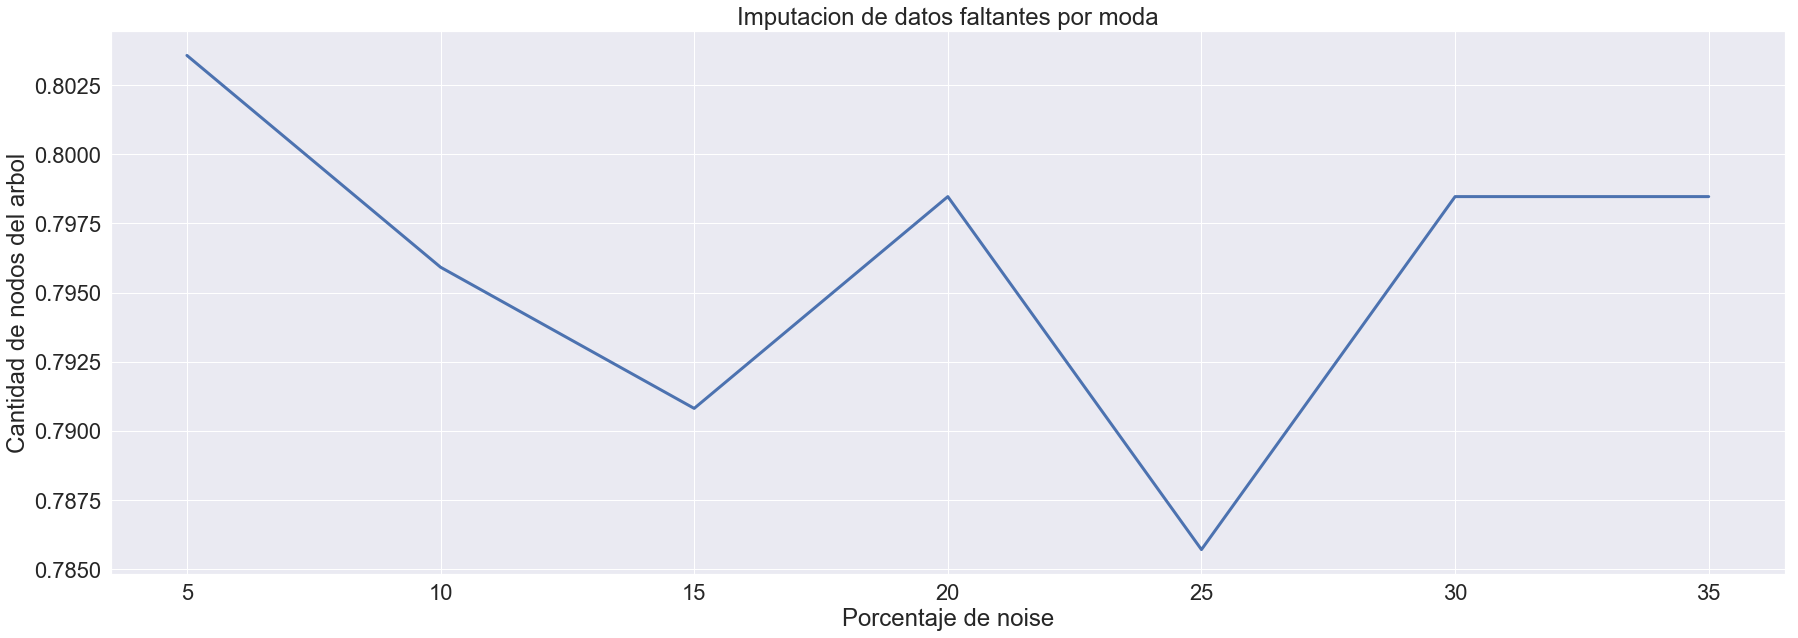

In [58]:
sns.set(font_scale=2)
fig, ax1 = plt.subplots()
ax1.plot(df_results_2_4["noise"], df_results_2_4["accuracy"], linewidth=3.0)
ax1.set_xlabel('Porcentaje de noise')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cantidad de nodos del arbol')
plt.title("Imputacion de datos faltantes por moda")
plt.show()

### e) Analizamos los resultados: 

## 3 Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Entrenamos el modelo con los datos de train y predecimos sobre test. Los resultamos que vamos a obtener son las probabilidades que el modelo asigna para cada clase posible (recordemos que en este caso son solo 2: compro o no compro)

In [ ]:
clf = GaussianNB()

scoring = ['accuracy','roc_auc']

scores_nb = cross_validate(clf, # Instancia de árbol a entrenar en cada fold
                        df_train.drop(columns=['target']).values, # X_train features
                        df_train["target"].values, # Y_train targets
                        scoring=scoring, # Pedimos que para fold se ejecute esta lista de scorings
                        return_train_score = True, # Queremos ver los scorings de los training folds
                        return_estimator = True, # Ademas, pedimos que se nos devuelvan los dtrees de entrenados
                        cv=5, # Establecemos la cantidad de particiones para realizar la Validación cruzada
                        n_jobs = -1 # Pedimos que se ejecute en paralelo, utilizando todos los cores
                       )
scores_nb

In [ ]:
cv_5_fold_resultados_naive_bayes = pd.DataFrame(scores_nb)

cv_5_fold_resultados_naive_bayes.drop(["fit_time","score_time","estimator"],axis=1,inplace=True)

cv_5_fold_resultados_naive_bayes

In [ ]:
cv_5_fold_resultados_naive_bayes.describe()

In [ ]:
best_naive_bayes_index = np.argmax(scores_nb["test_accuracy"]*scores_nb["test_roc_auc"])

In [ ]:
best_naive_bayes = scores["estimator"][best_naive_bayes_index]

y_esperado_nb = df_test.target.values

y_pred_nb = best_naive_bayes.predict(df_test[feature_columns].values)

#### Accuracy del modelo naive bayes sobre el dataset de test

In [ ]:
print("Score validation: " + str(accuracy_score(y_esperado_nb, y_pred_nb)))

#### Obtenemos las probabilidades de pertenecia a cada clase que el modelo calcula para cada observacion de test

In [ ]:
def prior_probabilities(model, dataset):
    
    y_pred = model.predict_proba(dataset.drop(columns=['target']))
    
    array_pred_class_0 = []
    
    array_pred_class_1 = []
    
    for prediction in y_pred:
        
        array_pred_class_0.append('{:f}'.format(prediction[0]))
        
        array_pred_class_1.append('{:f}'.format(prediction[1]))
    
    d = {'proba_class_0': array_pred_class_0, 'proba_class_1': array_pred_class_1}
    
    df = pd.DataFrame(data=d)
    
    return df     

In [ ]:
prior_probabilities(best_naive_bayes, df_test).head()

#### Obtenemos las probabilidades condicionales para un atributo del dataset

In [ ]:
def get_conditional_probabilities_attribute(dataframe, name_attribute):
    
    df = dataframe.copy()
    
    df['target_no'] = np.where(df['target'] == 0, 1, 0)
    
    d = {'target': ['sum'], 'target_no': ['sum']}

    df_cond = df.groupby([name_attribute]).agg(d)

    df_cond.columns = ['_'.join(col) for col in df_cond.columns.values]

    df_cond = df_cond.reset_index()

    df_cond['target_yes'] = round(df_cond['target_sum']/df_cond['target_sum'].sum(),3)
    
    df_cond['target_no'] = round(df_cond['target_no_sum']/df_cond['target_no_sum'].sum(),3)
    
    df_cond = df_cond.drop(columns=['target_sum', 'target_no_sum'])
    
    return df_cond

#### Por ejemplo, dado el valor de 1 para target, la probabilidad de que 'Android' tome el valor de 0 es de 0,594 

In [ ]:
df_test = get_conditional_probabilities_attribute(df_train, 'Android')

print(df_test.head())

df_test['target_yes'].sum()

## 4
### En primer lugar vamos a utilizar GridSearch para obtener los hiperparametros que maximizan la performance del modelo

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'max_depth':[3,5,6,7,9],
               'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [3,6,9]
             }

dtree = DecisionTreeClassifier()

dtree_best = GridSearchCV(cv=5, n_jobs=-1, estimator=dtree, param_grid = param_grid, scoring='roc_auc')

dtree_best = dtree_best.fit(df_train.drop(columns='target'), df_train['target'])

In [ ]:
print(dtree_best.best_score_)
print(dtree_best.best_params_)

In [ ]:
y_predicted = dtree_best.predict(df_test.drop(columns=['target']))

print("Roc_auc decisition tree: " + str(roc_auc_score(df_test['target'], y_predicted)))

In [ ]:
print("Roc_auc naive bayes: " + str(roc_auc_score(y_esperado_nb, y_pred_nb)))